# Final Project: Earth Analytics Python Course, Spring 2020
Steph Shepherd & Lauren Herwehe

A Big Dam Problem:
Global Dam Watch (http://globaldamwatch.org/) maintains a database of existing (GRandD)and future (FHReD) dams across the globe.  In this project we explore the future dams database by continent and country, identifying any proposed dams that will potentially impact Ramsar sites - wetlands designated of critical importance under the Ramsar Convention (1971). 

## Import packages, define functions, and acquire data

In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon

import contextily as ctx
import earthpy as et
import earthpy.plot as ep

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Custon Function 1
def dam_impact(buff_km, country):
    """ This function takes a country name, pulls the proposed 
    dams & ramsar areas for the country, creates a 5km & 10km 
    buffer around the dams, and returns the total ramsar area covered
    by each buffer.

    Parameters
    ----------
    buff_km: int or float
        The number of kilometers buffer you want around the dam.
    country: str
        Full name of the country to be analyzed in quotes.

    Returns
    -------
    ramsar_affected: float
        Total ramsar area affected in the country by proposed dams with buffer.
    """
    # Pull only the data for the country
    proposed_dams_cntry = proposed_dams[proposed_dams['Country'] == country]
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]

    # Buffer the dams to 5km & 10km to create gdfs of only the intersections
    proposed_dams_cntry['geometry'] = proposed_dams_cntry.buffer(
        buff_km * 1000)
    try:
        data_intersect_cntry = gpd.overlay(
            ramsar_areas_cntry, proposed_dams_cntry, how='intersection')
        # divide by 1 million because it sq km
        ramsar_affected = ((data_intersect_cntry.area.sum())/1000000).round(1)
        return ramsar_affected
    except IndexError as err:
        Dams = None

In [4]:
# Custom Function 2
def autolabel(rects): # width, dataframe, width, label are other
    """Attach a text label above each bar in *rects*, displaying its value.
    
    Parameters
    ----------
    rect: list 
        The list of values or count of items for the category.
    
    Returns
    -------
    label: int
        The value or count of items in a category.
    """
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [5]:
# Custom function 3
# This function isn't used in this notebook but will be useful for future analysis
def ramsar_area(country):
    """ This function takes a country name and pulls the total area of Ramsar Designated sites for it.

    Parameters
    ----------
    country: str
        Full name of the country to be analyzed in quotes (e.g. 'Mexico').

    Returns
    -------
    total_ramsar: float
        Total area of Ramsar sites in the country.

    """
    # Pull only the data for the country & calculate total area
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]
    total_ramsar = ((ramsar_areas_cntry.area.sum())/1000000).round(1)

    return total_ramsar

In [6]:
# Download Data stored on figshare
# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Future dams
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

'/home/jovyan/earth-analytics/data/earthpy-downloads/country-borders'

In [7]:
# Open the ramsar shapefile with geopandas
ramsar_all = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Check the crs of the ramsar sites
print(ramsar_all.crs)

# Open the dams csv files with pandas
fname = os.path.join("earthpy-downloads", "future_dams_2015.csv")
df = pd.read_csv(fname)

# Covert the pandas dataframe to a shapefile for plotting
# Set output path for shp
dams_path = os.path.join('final-project-data', 'fhred-proposed-dams')
if not os.path.exists(dams_path):
    os.mkdir(dams_path)

# Define the geometry for the points
geometry = [Point(xy) for xy in zip(df.Lon_Cleaned, df.LAT_cleaned)]
crs = {'init': 'epsg:4326'}
geo_df = gdf(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(
    dams_path, 'proposed_dams.shp'))

# Open the proposed dams shapefile with geopandas
dams_all = gpd.read_file(os.path.join(dams_path, "proposed_dams.shp"))

# Pull only the columns that we need from each gdf to save processing time
proposed_dams = dams_all[['Country',
                               'Continent', 'Major Basi', 'Stage', 'geometry']]
ramsar_areas = ramsar_all[['country_en', 'geometry']]

# Open country borders shapefile for adding boundary of study area
country_borders_path = os.path.join("earthpy-downloads", "country-borders",
                                    "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")
country_borders = gpd.read_file(country_borders_path)

epsg:4326


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Figure 1: Global Map of Dams and Ramsar Sites


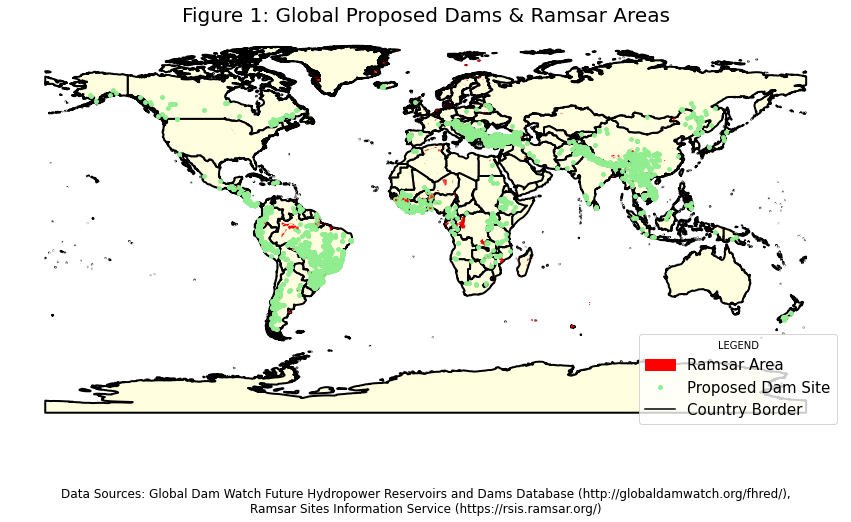

In [8]:
# Create a Global Map of Dams and Ramsar Sites
red_patch = mpatches.Patch(color='red', label='Ramsar Area')
green_dot = mlines.Line2D([], [], color='white', marker='o',
                          markerfacecolor='lightgreen', label='Proposed Dam Site')
black_line = mlines.Line2D([], [], color='black', label='Country Border')

fig, ax = plt.subplots(figsize=(15, 25))
country_borders.plot(ax=ax, color="lightyellow",
                     edgecolor="black", linewidth=2)
proposed_dams.plot(ax=ax,
                   markersize=15,
                   color='lightgreen', legend=True)
ramsar_areas.plot(ax=ax, facecolor='red', legend=True)
ax.set_title(
    'Figure 1: Global Proposed Dams & Ramsar Areas', size=20)
ax.set_axis_off()
ax.text(0.5, -0.2, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/),\nRamsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[red_patch, green_dot, black_line],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

# Figures 2-3: Plots of Future Dams by Continent and Selected Countries

In [9]:
# Getting Number of Dams by Continent and Development State
# Extact the columns needed for analysis
dams_continent = dams_all[['Continent', 'Country', 'Stage']]

# Group and count data by stage.
dams_stage = dams_continent.groupby(['Continent', 'Country', 'Stage'])[
    ['Stage']].count()

dams_stage

Stage
Continent     Country      Stage       
Africa        Angola       P          4
              Benin        P          6
              Burkina Faso P          2
              Burundi      P          2
                           U          1
...                                 ...
South America Guyana       P          3
                           U          1
              Peru         P         37
                           U         10
              Venezuela    P          3

[157 rows x 1 columns]

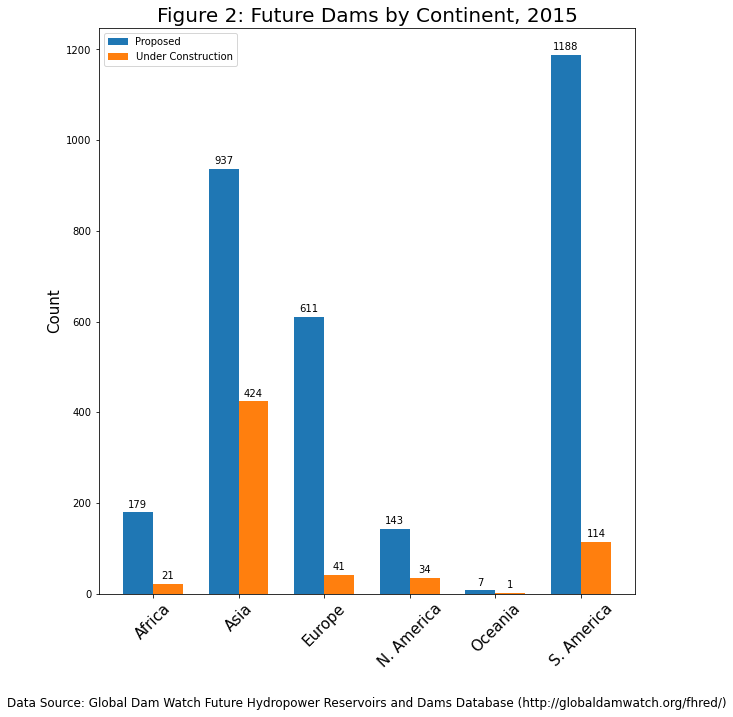

In [10]:
# PLOT - NUMBER OF DAMS PROPOSED VS UNDER CONSTRUCTION BY CONTINENT
# Create a bar plot of the dams by continent and stage of process.
labels = ['Africa', 'Asia', 'Europe', 'N. America', 'Oceania', 'S. America']
proposed = [179, 937, 611, 143, 7, 1188]
under_const = [21, 424, 41, 34, 1, 114]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', size=15)
ax.set_title('Figure 2: Future Dams by Continent, 2015', size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, size=15, rotation=45)
ax.legend()

autolabel(rects1)
autolabel(rects2)

ax.text(0.5, -0.2, "Data Source: Global Dam Watch Future Hydropower "
        "Reservoirs and Dams Database (http://globaldamwatch.org/fhred/)",
        size=12, ha="center", transform=ax.transAxes)
fig.tight_layout()

plt.show()

In [11]:
# Extract data by continent.
africa = dams_continent[dams_continent["Continent"] == "Africa"]

# Group and count country data by stage.
africa_stage = africa.groupby(['Country', 'Stage'])[['Stage']].count()

africa_stage

Stage
Country                  Stage       
Angola                   P          4
Benin                    P          6
Burkina Faso             P          2
Burundi                  P          2
                         U          1
Cameroon                 P          7
                         U          1
Central African Republic P          1
Congo, Rep.              P          8
Côte d'Ivoire            P         12
                         U          1
Egypt, Arab Rep.         P          1
Ethiopia                 P         13
                         U          4
Gabon                    P          1
                         U          1
Ghana                    P         11
                         U          1
Guinea                   P         23
Kenya                    P          6
Lesotho                  P          2
Liberia                  P          7
Malawi                   P          2
Mali                     P         12
                         U          1
Morocco                  U          2
Mozambique               P          3
                         U          1
Namibia                  P          3
Niger                    P          1
                         U          1
Nigeria                  P          1
                         U          2
Rwanda                   U          1
S. Sudan                 P          5
Sierra Leone             P          6
South Africa             P          3
Sudan                    P          3
                         U          1
Tanzania                 P          7
Togo                     P          1
Uganda                   P         15
                         U          1
Zambia                   P          9
                         U          1
Zimbabwe                 P          2
                         U          1

In [12]:
#Extract data by continent.
asia = dams_continent[dams_continent["Continent"] == "Asia"]

#Group and count country data by stage.
asia_stage = asia.groupby(['Country','Stage'])[['Stage']].count()

asia_stage

Stage
Country          Stage       
Afghanistan      P          3
                 U          2
Bangladesh       U          1
Bhutan           P          4
                 U          8
Cambodia         P         13
                 U          2
China            P         97
                 U        141
Georgia          P          5
                 U         15
India            P        109
                 U         72
Indonesia        U          7
Iran             U          7
Japan            U          4
Korea, Dem. Rep. U          1
Kyrgyzstan       P          1
Lao PDR          P         75
                 U          6
Malaysia         P          4
                 U          2
Mongolia         P          1
Myanmar          P         22
                 U          4
Nepal            P        239
                 U         46
Pakistan         P         48
                 U          9
Philippines      U          7
Russia           P          2
Sri Lanka        P          1
                 U          2
Tajikistan       U          1
Turkey           P        310
                 U         36
Uzbekistan       U          1
Vietnam          P          3
                 U         50

In [13]:
#Extract data by continent.
europe = dams_continent[dams_continent["Continent"] == "Europe"]

#Group and count country data by stage.
europe_stage = europe.groupby(['Country','Stage'])[['Stage']].count()

europe_stage

Stage
Country                Stage       
Albania                P         93
                       U          7
Austria                P         22
                       U          3
Belarus                P          2
                       U          5
Bosnia and Herzegovina P        118
                       U          4
Bulgaria               P         42
                       U          7
Croatia                P         80
                       U          1
France                 P          1
Greece                 P          4
                       U          2
Hungary                P          1
Iceland                P          3
                       U          1
Kosovo                 P         23
Macedonia              P         22
                       U          1
Montenegro             P         83
Poland                 P          1
Portugal               P          7
                       U          3
Romania                P          1
                       U          1
Russia                 P          8
                       U          3
Serbia                 P         59
Slovenia               P         41
                       U          1
Spain                  U          1
United Kingdom         U          1

In [14]:
#Extract data by continent.
n_america = dams_continent[dams_continent["Continent"] == "North America"]

#Group and count country data by stage.
n_america_stage = n_america.groupby(['Country','Stage'])[['Stage']].count()

n_america_stage

Stage
Country       Stage       
Belize        P          1
Canada        P         26
              U          8
Costa Rica    P         40
              U          3
El Salvador   P          1
Guatemala     U          2
Haiti         P          1
Honduras      U          2
Mexico        P          4
              U          3
Nicaragua     P         17
              U          1
Panama        P         43
              U         15
United States P         10

In [15]:
#Extract data by continent.
oceania = dams_continent[dams_continent["Continent"] == "Oceania"]

#Group and count country data by stage.
oceania_stage = oceania.groupby(['Country','Stage'])[['Stage']].count()

oceania_stage

Stage
Country          Stage       
New Zealand      P          6
Papua New Guinea P          1
                 U          1

In [16]:
#Extract data by continent.
s_america = dams_continent[dams_continent["Continent"] == "South America"]

#Group and count country data by stage.
s_america_stage = s_america.groupby(['Country','Stage'])[['Stage']].count()

s_america_stage

Stage
Country        Stage       
Argentina      P         68
               U          2
Bolivia        P         22
               U          2
Brazil         P        954
               U         73
Chile          P         19
               U          9
Colombia       P         25
               U          5
Dominican Rep. U          2
Ecuador        P         57
               U         10
Guyana         P          3
               U          1
Peru           P         37
               U         10
Venezuela      P          3

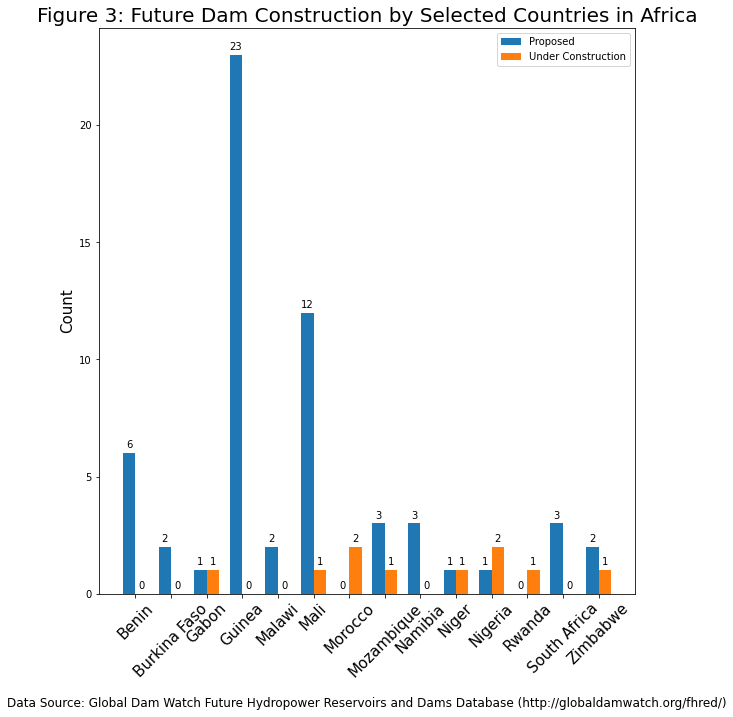

In [17]:
# Create a bar plot of the dams by countries in Africa comparing stage of process.
africa_labels = ['Benin', 'Burkina Faso', 'Gabon', 'Guinea', 'Malawi', 'Mali', 'Morocco',
                 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'South Africa', 'Zimbabwe']
africa_proposed = [6, 2, 1, 23, 2, 12, 0, 3, 3, 1, 1, 0, 3, 2]
africa_under_const = [0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1]

x = np.arange(len(africa_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, africa_proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, africa_under_const,
                width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', size=15)
ax.set_title(
    'Figure 3A: Future Dam Construction by Selected Countries in Africa', size=20)
ax.set_xticks(x)
ax.set_xticklabels(africa_labels, size=15, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

ax.text(0.5, -0.2, "Data Source: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/)",
        size=12, ha="center", transform=ax.transAxes)

fig.tight_layout()

plt.show()

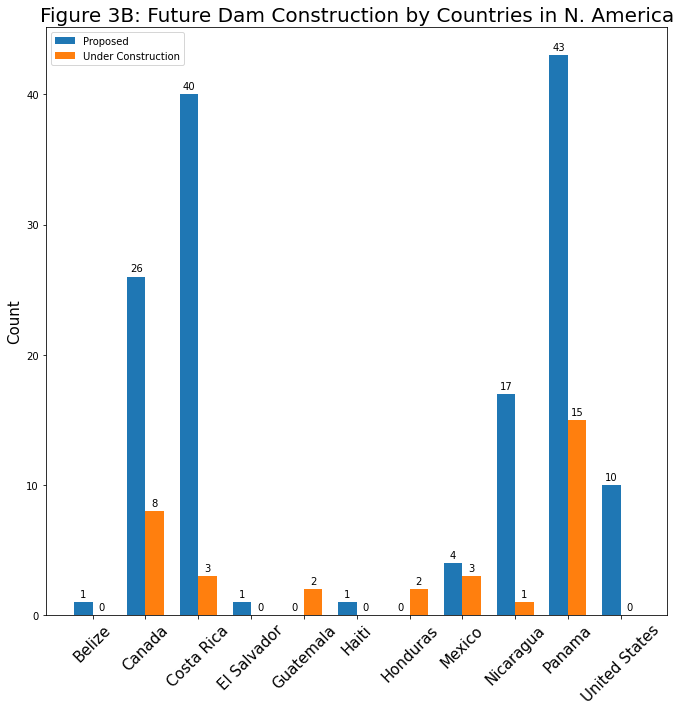

In [18]:
# Create a bar plot of the dams by country in N. America comparing stage of process.
na_labels = ['Belize', 'Canada', 'Costa Rica', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'United States']
na_proposed = [1, 26, 40, 1, 0, 1, 0, 4, 17, 43, 10]
na_under_const = [0, 8, 3, 0, 2, 0, 2, 3, 1, 15, 0]

x = np.arange(len(na_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, na_proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, na_under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', size=15)
ax.set_title('Figure 3B: Future Dam Construction by Countries in N. America', size=20)
ax.set_xticks(x)
ax.set_xticklabels(na_labels, size=15, rotation=45)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Overlay future dams and Ramsar sites datasets for Africa.

In [19]:
# Change the datas CRS to projected for Africa (WGS 84 World Mercator)
# To make this data more accurate, for the next course we can create 
#list of EPSG for each country in Africa to include in function
proposed_dams = proposed_dams.to_crs('epsg:3765')
ramsar_areas = ramsar_areas.to_crs('epsg:3765')

In [20]:
# Get dam impact by African country
# List of African country names
# Data cleaning issues: Removed 'Côte d'Ivoire' bc in Ramsar dataset it's called Cite D'ivore and don't know how to deal with additional ' in a string; also removed Congo bc in Ramsar it's called Congo & Democratic Republic of Congo and in FhRED it's called Congo, Rep.
africa_cntry = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
                'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
                'Chad', 'Comoros', 'Djibouti', 'Equatorial Guinea', 'Eritrea',
                'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
                'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 
                'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 
                'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 
                'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
                'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

# Empty Africa dict
africa_dams = {}

# Append dam_impact function data to africa_dams
for i in africa_cntry:
    try:
        africa_dams[i] = {"5km Buffer Area": dam_impact(
            5, i), "10km Buffer Area": dam_impact(10, i)}
    except:
        dams = None

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [21]:
# Turn it into a pandas dataframe for plotting
africa_df = pd.DataFrame.from_dict(africa_dams)

# Some values in the dataframe are zero and some are NaN, make it the same
africa_df = africa_df.fillna('None')
africa_df.replace({0: 'None'})

Angola  Benin Botswana Burkina Faso Burundi Cameroon  \
5km Buffer Area    None  247.9     None         None    None     None   
10km Buffer Area   None  972.5     None         None    None     None   

                 Central African Republic  Chad Comoros Djibouti  ...  \
5km Buffer Area                      None  None    None     None  ...   
10km Buffer Area                     None  None    None     None  ...   

                 Sierra Leone Somalia South Africa South Sudan Sudan Tanzania  \
5km Buffer Area          None    None         None        None  None     None   
10km Buffer Area         None    None         None        None  None     None   

                  Togo Uganda Zambia Zimbabwe  
5km Buffer Area   None   None   None     None  
10km Buffer Area  None   None   None     None  

[2 rows x 40 columns]

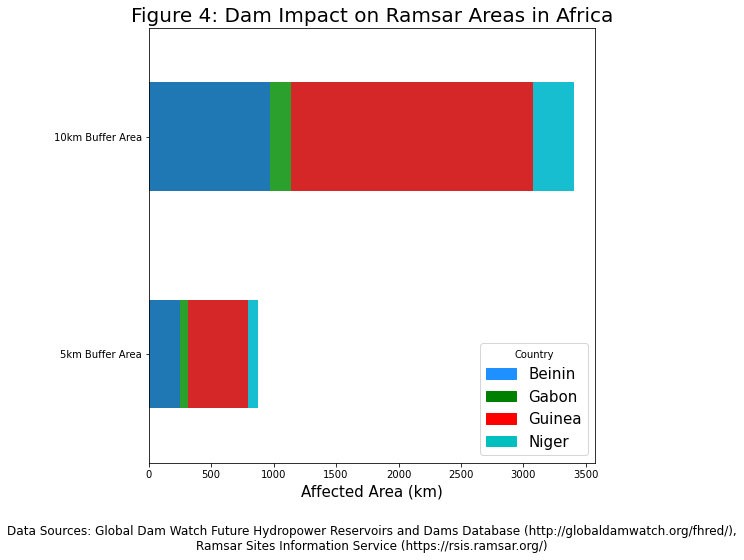

In [22]:
#Plot data to illustrate which countires have potential imapcts from proposed dams.
# Create legend so only countries with potential impacts are listed.
blue_patch = mpatches.Patch(color='dodgerblue', label='Beinin')
green_patch = mpatches.Patch(color='green', label='Gabon')
red_patch = mpatches.Patch(color='red', label='Guinea')
teal_patch = mpatches.Patch(color='c', label='Niger')

# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))
africa_df.plot(ax=ax, kind='barh', stacked=True, legend=True)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Affected Area (km)', size=15)
ax.set_title('Figure 4: Dam Impact on Ramsar Areas in Africa', size=20)
ax.text(0.5, -0.2, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/),\nRamsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[blue_patch, green_patch, red_patch, teal_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="Country")

# Map buffer results for Guinea

In [23]:
# Analyze Guinea
# Pull only the data for Guinea
proposed_dams_guin = proposed_dams[proposed_dams['Country'] == "Guinea"]
ramsar_areas_guin = ramsar_areas[ramsar_areas['country_en'] == "Guinea"]
guinea_border = country_borders[country_borders['CNTRY_NAME'] == "Guinea"]

# Get the CRS right for plotting
proposed_dams_guin = proposed_dams_guin.to_crs('epsg:3462')
ramsar_areas_guin = ramsar_areas_guin.to_crs('epsg:3462')
guinea_border = guinea_border.to_crs('epsg:3462')

# Buffer the dams to 5km & 10km for plotting
proposed_dams_guin_5k_buff = proposed_dams_guin.buffer(5000)
proposed_dams_guin_10k_buff = proposed_dams_guin.buffer(10000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


Text(0.5, -0.1, 'Data Sources: Global Dam Watch Future Hydropower Reservoirs and Dams Database (http://globaldamwatch.org/fhred/), \n Ramsar Sites Information Service (https://rsis.ramsar.org/)')

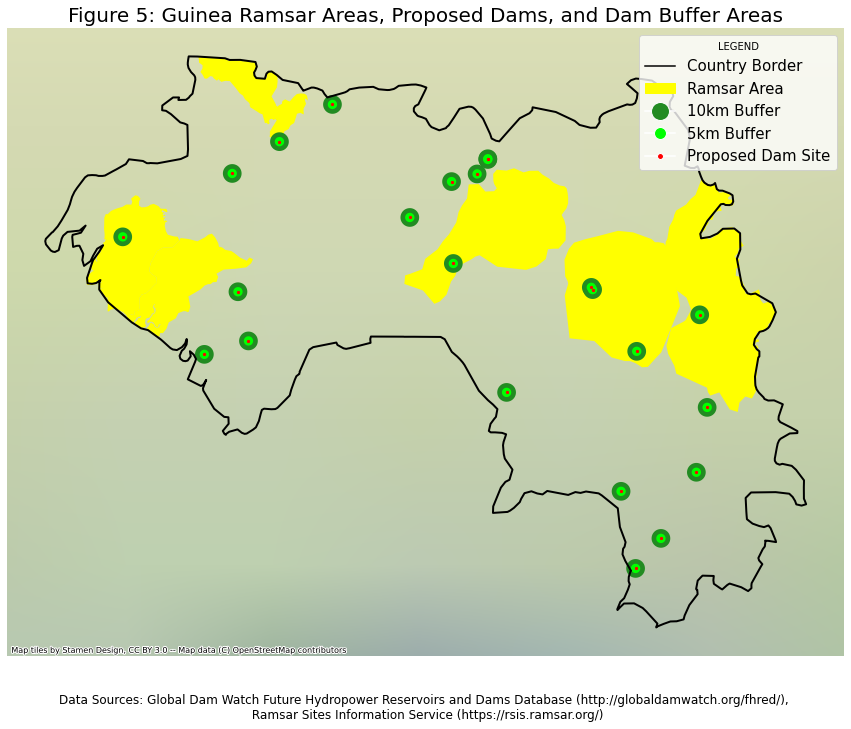

In [24]:
# Create a map of the dams and the ramsar sites for Guinea
black_line = mlines.Line2D([], [], color='black', label='Country Border')
yellow_patch = mpatches.Patch(color='yellow', label='Ramsar Area')
green_circle = mlines.Line2D([], [], color='white', marker='o',
                             markerfacecolor='forestgreen', markersize=18, 
                             label='10km Buffer')
lime_circle = mlines.Line2D([], [], color='white', marker='o',
                            markerfacecolor='lime', markersize=12, 
                            label='5km Buffer')
red_dot = mlines.Line2D([], [], color='white', marker='o',
                        markerfacecolor='red', label='Proposed Dam Site')

fig, ax = plt.subplots(figsize=(15, 15))
ramsar_areas_guin.plot(ax=ax, facecolor='yellow')
proposed_dams_guin_10k_buff.plot(facecolor='forestgreen',
                                 ax=ax)
proposed_dams_guin_5k_buff.plot(facecolor='lime',
                                ax=ax)
proposed_dams_guin.plot(ax=ax,
                        markersize=5,
                        color='red')
guinea_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ax.legend(handles=[black_line, yellow_patch, green_circle, lime_circle, red_dot],
          fontsize=15,
          frameon=True,
          loc=('upper right'),
          title="LEGEND")
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_axis_off()
ax.set_title(
    'Figure 5: Guinea Ramsar Areas, Proposed Dams, and Dam Buffer Areas', size=20)
ax.text(0.5, -0.1, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/), \n Ramsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)